# Parametric Circuit Fitting Belem

In [3]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
def regularized_fit(d, data, num_iter_spam=1000, num_iter_map=2000, N=500, weight=1, start = 1):
    
    inputs_spam, targets_spam, inputs_map, targets_map = data
    
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = num_iter_spam,
               verbose = False,
              )
    model_fullrank = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=d**2,
                                               spam = spam,
                                               ),
                                     loss_function = ProbabilityMSE(),
                                     optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                     logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                                    )

    model_fullrank.train(inputs = inputs_map,
                         targets = targets_map,
                         num_iter = num_iter_map,
                         N = N,
                        )
    
    loss_ref = model_fullrank.logger.loss_train_list[-1]
    
    for rank in range(start, d**2):
        if rank == start:
            loss_prev = 1000
            
        model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=rank,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

        model.train(inputs = inputs_map,
                    targets = targets_map,
                    num_iter = num_iter_map,
                    N = N,
                    )
        
        loss = model.logger.loss_train_list[-1]
        if (rank)/(rank-1) > (loss_prev - loss_ref)/(loss - loss_ref):
            break
        model_final = model
        loss_prev = loss   
    
    return model_final

## No Delay

In [160]:
n = 3
d = 2**n

model1_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list = pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500)
    model1_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00927996084324855


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006703929239338329 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.030596402957813955 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019806113445328333 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01516115517170932 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.012531215939921896 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011008654271776542 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009815041017861853 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009207237230093457 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008622425662408088 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008194168984520972 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00795120726925509 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007688569316549482 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007442543410069699 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007351222852528865 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007208381697243125 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007107408784682078 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007069506586543148 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006967468230319435 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006930742135010198 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006893781430551128 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006871574782583805 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0068393197055430744 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006797359389073433 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006788924100532478 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006796988682411566 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00881556638615872


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007026848974798106 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.030379857739822613 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019787460624101194 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015024678179740989 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.012647491350810293 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010980929419836867 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009973525937691328 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00918741566872747 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008844564560580876 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008417901331039973 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008019492264675384 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007881484548216041 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007706403808399444 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00757257035950581 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007481569573210407 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0074138252567454935 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007352478510631283 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007281374679115702 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007219694104860209 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007193903156371854 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00715837437828857 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00715283367215967 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009141430170036595


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006927336611540914 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0299177210378364 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01896150699148274 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014421209954657569 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.012213915636010382 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010712008021692799 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009899952234955427 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009061100274187498 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008560066896867537 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008268922295192431 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007934235927687506 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0076916287369443335 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007642897854576329 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008438075471471549


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006355082573344696 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.03176734746120448 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.020003440336884976 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015087592641599736 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.012429097702442899 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01037822574792436 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009481326580831059 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00866663448303916 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008231569013845441 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007722240591915163 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007527958623473323 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007330593647824167 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007119157164966141 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006968498298755441 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006912311593203857 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0067680176203554964 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006737190350074296 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006647930459061721 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006604799640574963 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006549829017083737 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006534123361294988 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0064985564246255074 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006469562055983234 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0064466685446014915 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006438885433743388 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006438455590032439 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00873592252944787


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009079095458008007 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.041919372649806934 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02678160066632932 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02000483719117778 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.016631864908774836 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014590434873734404 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013372418807603294 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01222774730463765 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011376915568134062 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010883923548734463 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010472988088138421 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01017496803649391 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01001088448824582 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009784063938009745 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009660196101273492 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009579209897352435 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009493212911603767 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009420372572078693 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009403089014696579 None


## 5 us Delay

In [185]:
n = 3
d = 2**n

model2_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_5usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 15)
    model2_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008394945983070416


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006776880105799946 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007623933041645179 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007492602498479315 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007322175249454445 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007253634583293862 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0071257813164746775 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007106799375840516 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007047567360573995 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007005964237295027 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006968404479806852 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006930455782103285 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006900989765285093 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006871345158118946 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006863828663224663 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006839098314333158 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006823362917507715 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006824712471524944 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00892046797356302


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00821445917037374 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009132243733940584 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008859689644201526 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008750321775486902 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008717394408490413 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008603119682161682 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008539564509784315 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008514253939833998 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008411564069120888 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00840024365313206 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008380094645512409 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008346085633488634 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008320423254310835 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008296733097812327 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008296910444964866 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00894303267486445


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0075396810619636715 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008668788459803177 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008395145626097554 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00824751536680717 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008119655326004532 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007964883517459602 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00792810095886283 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007896995197656157 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007824706335246526 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007743630061321087 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0077113512526802664 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007694922722232912 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007688432905979559 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007636878469652029 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007622331052810464 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00760828037112155 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00760368519414531 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007586392077567178 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007590534173966009 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008697081534007094


  0%|          | 0/2000 [00:00<?, ?it/s]

0.044423146907391624 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.04527677329072894 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.04511788869243906 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0450136564325618 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.04483821994375711 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.04477120146762956 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.044645271001879296 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.04463011033220254 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.044555895214803604 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.044556912715930146 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009514388221095701


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0073177856714634745 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008230315919361927 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00801066008265039 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007916271153643429 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007765021156276441 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007717563573261288 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007648212791709639 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007589485286542305 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007527688988829766 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007492469581646732 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007484610511578419 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007442004686008901 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007427680828315004 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007405271350387106 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007392027144304748 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007377841347704974 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0073680924901413725 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007373561307836103 None


## 10 us Delay

In [186]:
n = 3
d = 2**n

model3_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 15)
    model3_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009911955845176169


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007750089512595392 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008798709487843713 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008604137037878665 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008424082738223895 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008332772732844763 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008229765651693649 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008136024495473895 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00807336449416744 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00798750528510152 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007963434820646877 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007954104885307274 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007870753669840094 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007880091509240903 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.010180620808476362


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008347527941993917 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009401663486345892 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009194362693856194 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00909748701559405 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008937154938029813 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008782718391360333 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008731397465333308 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00867963896405925 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008628561929274721 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008560116202307073 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008549260159496573 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008480392986131235 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008472998669212242 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008434807113291368 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00842931953912017 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008413283895045524 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00838753563362809 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008387730978871417 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009231679792540333


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010587690151822425 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011811107558969027 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011512142802675608 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011380327823526404 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011206136045579547 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011112081007763196 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011045828255698834 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010956330232878175 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010869714307239802 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010843987955145505 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010796820782476778 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010726360027511681 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01071930553160019 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010687887604746923 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010664994266013195 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010658061641960785 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010635363716100426 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010630407353662509 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010638737824547896 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008893707973330382


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008767067882523839 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010157685412212987 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009945585666543171 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009778464868535603 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009525322340879296 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00936102317743776 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00930568667321236 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009192835147635135 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009113282786704119 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009036452730990602 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009026260162657953 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008840330467105709


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011114448627991415 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0127020706824638 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.012395553044578475 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.012166733584200744 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011947224752047904 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011767767805724045 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011686744917088621 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01164363765778298 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011445169461937368 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01142087468996456 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011360103366171085 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01132627750518941 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01125360356228135 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011243454676548382 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01123256802208726 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011191833280317634 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011187516214637127 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011171078381014573 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011180677332102476 None


# 15 us Delay

In [187]:
n = 3
d = 2**n

model4_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_15usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 15)
    model4_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00916896295756937


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013754412623921838 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01590792570578167 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015404956101495617 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01532998268088529 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009296657313692431


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014366467066765053 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.016410093117880328 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015968907721537123 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01565383562041046 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015466828908913028 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015246617516596107 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015086227987146417 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015002015870615167 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014820329373802291 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014760866997839687 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014666727308698824 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014638693394568482 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014603136593631848 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014513503050111112 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01449446083416313 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014464837063478857 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014405329510216296 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014429992982680813 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.010147760082988464


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01809128878340532 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02035723335190414 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019864917440100483 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01950884953971824 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01928123392358997 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019005026381453783 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018911142909093164 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018761479152655983 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018645643663242686 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018493566774657168 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018434862824556073 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018350170642479482 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01832901162611887 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01827194937820236 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018262259522579427 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01819937966208243 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018201895392945755 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.005454906974879993


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006867647269213236 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008973899594550704 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008525193089170772 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008346900538611807 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008020215064768198 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007812777576164009 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0076710078960090375 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007590522372293144 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00747435490336505 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007350905433798656 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0072773179055671735 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007222912085635773 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007150691588004163 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007094414536189693 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007056393649677851 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007062758702171933 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008762972225254786


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008202702356178416 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01027104089984646 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009860985571337418 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009547766269541772 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009389420135194563 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009094166344489424 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008971767342632803 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00889712828343385 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008718914370704458 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008638876076681802 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0085660219298825 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00850977370686674 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00843135998119477 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008389746608230848 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008353501730587451 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008334614084085989 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008289456926437554 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008279830507514683 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008274895691061006 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008242669464447643 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008238898444917339 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008242220289462822 None


# 20 us Delay

In [3]:
n = 3
d = 2**n

model5_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 25)
    model5_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009018773144994446


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013170602199150802 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013362065400777426 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013340478108183455 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013320826604505561 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01326797007178085 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013254118056949142 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0132246619981626 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013212760714315843 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013208907127157905 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013200142085226865 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013216177067749257 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009566350794543673


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01142523056054148 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0116184385177187 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011562138161682934 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011539492958525964 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011505152450075247 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011502690046990834 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00862671144457633


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010186643797810584 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010425123077742345 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010339159274913735 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010308851494164556 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010302698323747639 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010277084737009943 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010246579503894382 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010249221077114928 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009560591435678237


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01360244674963955 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014077730425120784 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01398158866838317 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013929995821541445 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013867450928642526 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013809981341476917 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013820577517247466 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009963390080018786


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007585252127238923 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00805435888987444 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00795365509096339 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00790762094250001 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007852151658977301 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007790988597902073 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0078072431697411805 None


# 25 us Delay

In [190]:
n = 3
d = 2**n

model6_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 25)
    model6_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00898104112119714


  0%|          | 0/2000 [00:00<?, ?it/s]

0.022276255087357737 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.022474883225650964 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02242031859261526 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.022407332676126376 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.022381411202766235 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.022318804567235194 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0223397324828878 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009235262890597142


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013542298237968991 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013716063267128056 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01367959929696433 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013675457748795668 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009292336566737476


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019121197677605582 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019353522373732113 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019314929490131062 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019273790972838732 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019244497945212387 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019240918426857948 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009115962891386548


  0%|          | 0/2000 [00:00<?, ?it/s]

0.03439525413173796 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.03477987355951975 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.03469000770167664 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.034609750106756876 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.03462567582020627 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00883904949823907


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007509161343091643 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007925783742642578 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007871228612782446 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007790936037677725 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007775375457168068 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007725859360644715 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0076950970971433694 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007642245080449725 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007605390559540048 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0076239338984801395 None


In [5]:
#data1 = [model.channel for model in model1_list]
#data2 = [model.channel for model in model2_list]
#data3 = [model.channel for model in model3_list]
#data4 = [model.channel for model in model4_list]
data5 = [model.channel for model in model5_list]
#data6 = [model.channel for model in model6_list]

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


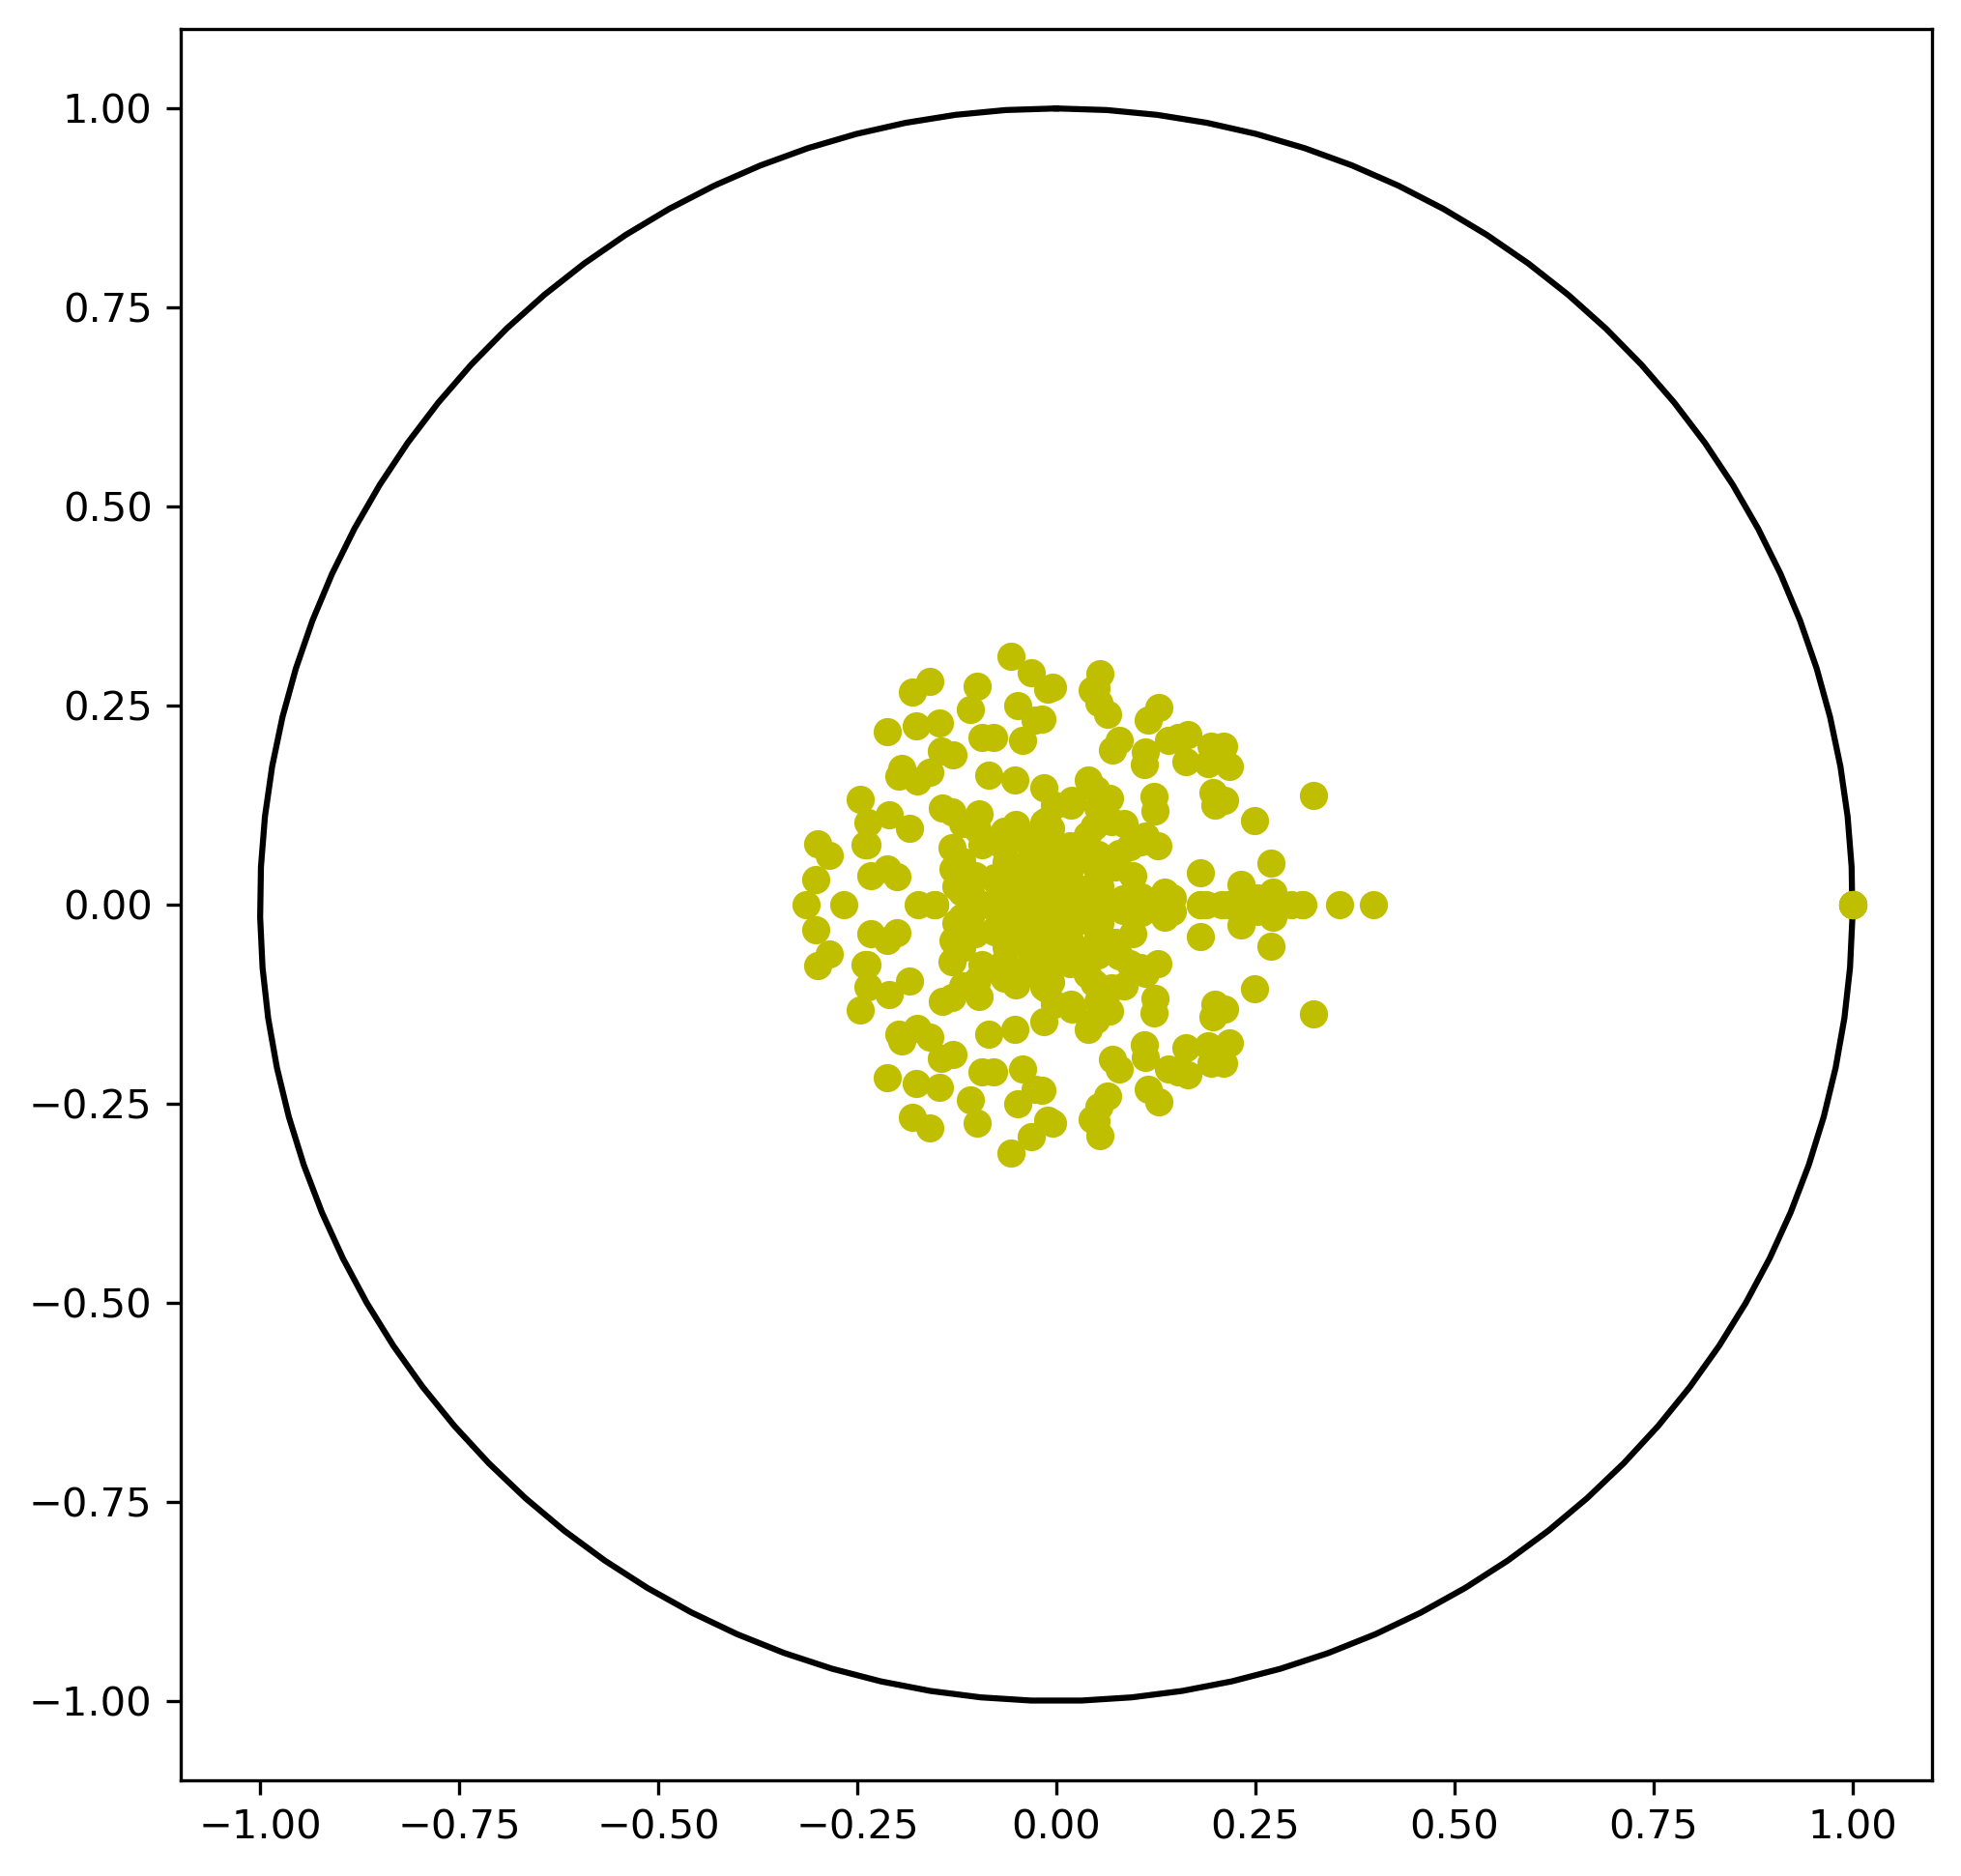

In [6]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

#spectrum1_list = [channel_spectrum(channel) for channel in data1]
#spectrum2_list = [channel_spectrum(channel) for channel in data2]
#spectrum3_list = [channel_spectrum(channel) for channel in data3]
#spectrum4_list = [channel_spectrum(channel) for channel in data4]
spectrum5_list = [channel_spectrum(channel) for channel in data5]
#spectrum6_list = [channel_spectrum(channel) for channel in data6]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

#for spectrum in spectrum1_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "bo")

#for spectrum in spectrum2_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "ro")

#for spectrum in spectrum3_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "go")

#for spectrum in spectrum4_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "co")

for spectrum in spectrum5_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "yo")

#for spectrum in spectrum6_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "ko")

plt.show()

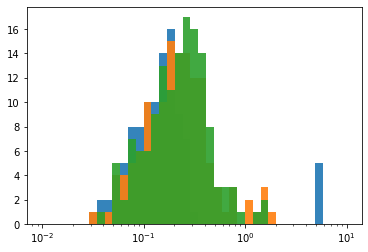

In [211]:
bins = np.logspace(-2, 1, 40)

eig1 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model1_list]))
eig2 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model2_list]))
eig3 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model3_list]))
eig4 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model4_list]))
eig5 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model5_list]))
eig6 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model6_list]))

plt.hist(eig1, bins=bins, alpha=0.9)
#plt.hist(eig2, bins=bins, alpha=0.5)
#plt.hist(eig3, bins=bins, alpha=0.5)
plt.hist(eig4, bins=bins, alpha=0.9)
#plt.hist(eig5, bins=bins, alpha=0.5)
plt.hist(eig6, bins=bins, alpha=0.9)

plt.xscale("log")
plt.show()

In [7]:
def spectrum_to_radial(spectrum):
    radial = tf.norm(spectrum, axis=1)
    return radial

def find_outer_inner_R(spectrum_list):
    L = len(spectrum_list)
    radial_list = np.array([np.sort(spectrum_to_radial(spectrum)) for spectrum in spectrum_list])
    R_minus = np.mean(radial_list[:,0])
    R_minus_std = np.std(radial_list[:,0])
    R_plus = np.mean(radial_list[:,-1])
    R_plus_std = np.std(radial_list[:,-1])
    return R_plus, R_minus, R_plus_std, R_minus_std

In [201]:
#R_p1, R_m1, R_pStd1, R_mStd1 = find_outer_inner_R([spectrum1_list[i][:-1] for i in range(5)])
#R_p2, R_m2, R_pStd2, R_mStd2 = find_outer_inner_R([spectrum2_list[i][:-1] for i in range(5)])
#R_p3, R_m3, R_pStd3, R_mStd3 = find_outer_inner_R([spectrum3_list[i][:-1] for i in range(5)])
#R_p4, R_m4, R_pStd4, R_mStd4 = find_outer_inner_R([spectrum4_list[i][:-1] for i in range(5)])
R_p5, R_m5, R_pStd5, R_mStd5 = find_outer_inner_R([spectrum5_list[i][:-1] for i in range(5)])
#R_p6, R_m6, R_pStd6, R_mStd6 = find_outer_inner_R([spectrum6_list[i][:-1] for i in range(5)])

In [202]:
x = [0, 5, 10, 15, 20, 25]
R_plus = [R_p1, R_p2, R_p3, R_p4, R_p5, R_p6]
R_minus = [R_m1, R_m2, R_m3, R_m4, R_m5, R_m6]
R_plus_std = [R_pStd1, R_pStd2, R_pStd3, R_pStd4, R_pStd5, R_pStd6]
R_minus_std = [R_mStd1, R_mStd2, R_mStd3, R_mStd4, R_mStd5, R_mStd6]

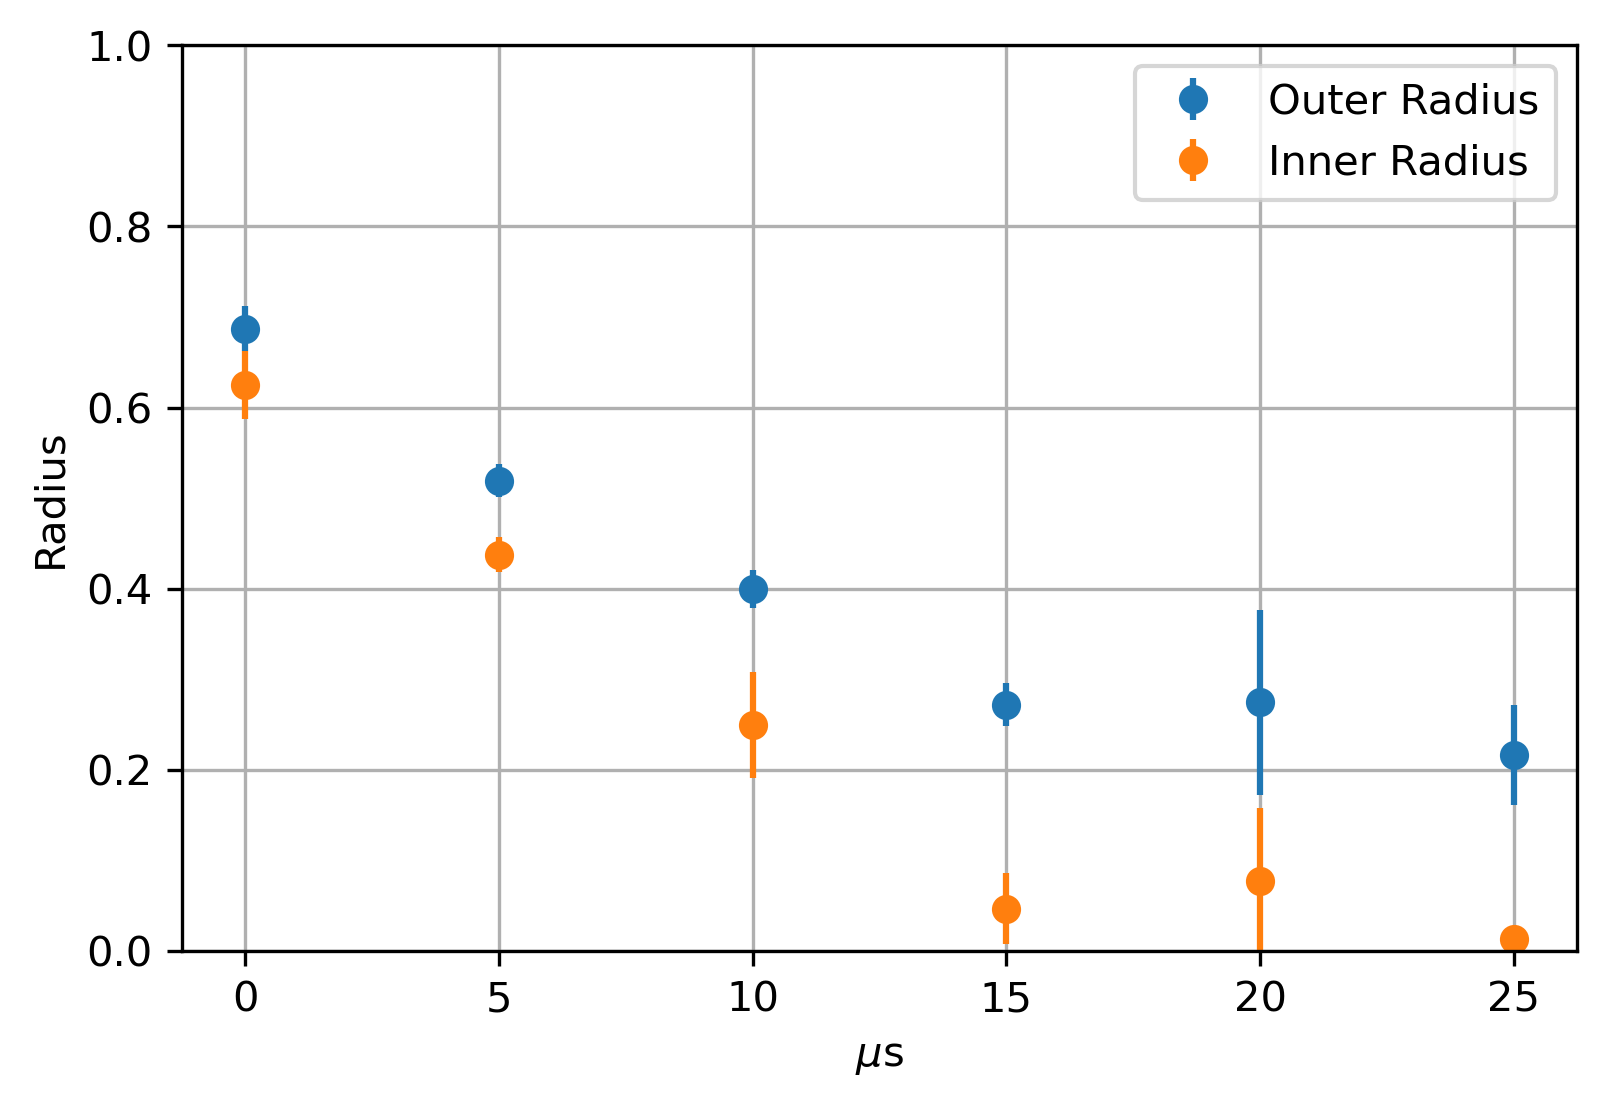

In [214]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, R_plus, yerr=R_plus_std, fmt="o")
plt.errorbar(x, R_minus, yerr=R_minus_std, fmt="o")
plt.ylim([0,1])
plt.grid()
plt.xlabel("$\mu$s")
plt.ylabel("Radius")
plt.legend(["Outer Radius", "Inner Radius"])
plt.show()

## Entangling Dissipation

In [5]:
inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_decay_belem.p", "rb"))
n=3
d=2**n


targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

inputs_spam, targets_spam, inputs_map, targets_map = data
    
spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
              num_iter = 300,
              verbose = False,
              )

spam.train(inputs = inputs_spam,
           targets = targets_spam,
           num_iter = 1000,
           verbose = False,
          )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=16,
                                               spam = spam,
                                              ),
                           loss_function = ProbabilityMSE(),
                           optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                           )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            N = 500,
            )  

  0%|          | 0/300 [00:00<?, ?it/s]

9.059889806118323e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.010216302971883121


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009233132282428988 None


In [13]:
X, A, B = generate_ginibre(2, 2, trainable=True)
X, C, D = generate_ginibre(2, 2, trainable=True)
X, E, F = generate_ginibre(2, 2, trainable=True)

In [7]:
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for i in range(2000):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([A,B,C,D,E,F])
        
        
        X1 = tf.cast(A, dtype=precision) + 1j*tf.cast(B, dtype=precision)
        XX1 = tf.matmul(X1, X1, adjoint_b=True)
        state1 = XX1/tf.linalg.trace(XX1)
        
        X2 = tf.cast(C, dtype=precision) + 1j*tf.cast(D, dtype=precision)
        XX2 = tf.matmul(X2, X2, adjoint_b=True)
        state2 = XX2/tf.linalg.trace(XX2)
        
        X3 = tf.cast(E, dtype=precision) + 1j*tf.cast(F, dtype=precision)
        XX3 = tf.matmul(X3, X3, adjoint_b=True)
        state3 = XX3/tf.linalg.trace(XX3)

        
        state = tf.expand_dims(kron(state1,state2,state3), axis=0)

        state = model.channel.apply_channel(state)
        state = partial_transpose(state, qubit=0)

        eig, _ = tf.linalg.eigh(state)
        eig = tf.math.real(eig)
        loss = tf.math.reduce_min(eig) + tf.math.reduce_sum(eig[eig<0]) - tf.math.reduce_min(eig[eig<0])
        grads = tape.gradient(loss, [A,B,C,D,E,F])
        optimizer.apply_gradients(zip(grads, [A,B,C,D,E,F]))
        print(loss.numpy())

-0.12289562705201908
-0.12642606375729662
-0.1298502295909535
-0.13316246612285354
-0.13636012748386533
-0.13944132572892115
-0.14240330494612405
-0.14524335085224582
-0.1479591747991709
-0.15054881812222357
-0.15301079973717957
-0.15534426732385362
-0.15754914410909276
-0.159626195829168
-0.1615770416915094
-0.1634040641934596
-0.1651101975337997
-0.16669870330246458
-0.16817297954743257
-0.1695365195345231
-0.17079303497545106
-0.17194663626624473
-0.17300199369641853
-0.17396437668271314
-0.17483954560902182
-0.17563358792819903
-0.1763527234756108
-0.1770031702200699
-0.1775910349812279
-0.1781222422412044
-0.17860248574931423
-0.17903720622650265
-0.1794315943979059
-0.17979059158692198
-0.18011889465735922
-0.18042095566664187
-0.18070096983215714
-0.1809628472174519
-0.18121017383893828
-0.181446173859854
-0.18167368100426073
-0.18189512986050152
-0.1821125717970449
-0.1823277086704913
-0.18254193500934504
-0.18275637865019134
-0.18297192863590983
-0.18318924836808193
-0.1834087

-0.1995287467423615
-0.1995288199413088
-0.19952889206337282
-0.19952896314209992
-0.1995290331852558
-0.1995291022036455
-0.19952917020644487
-0.19952923722661633
-0.19952930327201057
-0.19952936836281854
-0.1995294325142827
-0.19952949573402226
-0.19952955803916506
-0.19952961946290862
-0.19952967999808383
-0.19952973965723295
-0.1995297984583978
-0.1995298564130126
-0.1995299135508203
-0.19952996986506374
-0.19953002536563297
-0.19953008008720888
-0.1995301340214027
-0.19953018718464827
-0.19953023959514965
-0.19953029125874855
-0.19953034219469734
-0.1995303924079008
-0.19953044190876096
-0.19953049071659393
-0.19953053882403016
-0.19953058625225945
-0.19953063301818527
-0.19953067912891162
-0.19953072458487686
-0.1995307694027955
-0.19953081359858846
-0.199530857172986
-0.19953090013958596
-0.19953094250069855
-0.19953098427345167
-0.19953102545959706
-0.19953106606903484
-0.19953110610950178
-0.1995311455959297
-0.19953118453152568
-0.19953122292373882
-0.19953126077597635
-0.199

-0.19953399767336677
-0.19953399794209517
-0.19953399820646475
-0.19953399846710831
-0.19953399872396055
-0.19953399897717894
-0.1995339992262985
-0.19953399947170192
-0.19953399971370409
-0.19953399995173288
-0.1995340001866644
-0.19953400041775887
-0.19953400064540755
-0.1995340008693403
-0.1995340010900127
-0.19953400130759227
-0.19953400152159068
-0.19953400173290406
-0.19953400194076318
-0.19953400214548672
-0.19953400234715518
-0.19953400254537956
-0.1995340027411377
-0.19953400293339896
-0.19953400312292233
-0.1995340033094968
-0.199534003493522
-0.19953400367434723
-0.19953400385274447
-0.19953400402813123
-0.19953400420125403
-0.19953400437138052
-0.1995340045392835
-0.19953400470429433
-0.19953400486694428
-0.19953400502702245
-0.19953400518465944
-0.1995340053398545
-0.19953400549282496
-0.19953400564307103
-0.19953400579133077
-0.19953400593704024
-0.19953400608072386
-0.19953400622189885
-0.19953400636115695
-0.1995340064984776
-0.1995340066335382
-0.19953400676658833
-0.1

-0.19953401479056404
-0.19953401479075733
-0.19953401479094715
-0.1995340147911344
-0.19953401479131477
-0.19953401479149188
-0.19953401479166674
-0.19953401479183894
-0.19953401479200747
-0.19953401479217692
-0.19953401479233432
-0.19953401479248803
-0.19953401479263902
-0.1995340147927879
-0.19953401479293306
-0.19953401479307545
-0.19953401479321625
-0.19953401479335467
-0.19953401479349078
-0.19953401479362315
-0.1995340147937534
-0.19953401479388252
-0.19953401479401023
-0.19953401479413355
-0.1995340147942544
-0.199534014794374
-0.19953401479448943
-0.1995340147946034
-0.1995340147947152
-0.19953401479481384
-0.19953401479490981
-0.19953401479500726
-0.19953401479510657
-0.199534014795203
-0.19953401479529753
-0.19953401479538596
-0.199534014795479
-0.19953401479556615
-0.19953401479565203
-0.19953401479573635
-0.19953401479581911
-0.19953401479590116
-0.19953401479598257
-0.19953401479606359
-0.19953401479614102
-0.19953401479621868
-0.19953401479629662
-0.19953401479637323
-0.1

-0.19953401479957913
-0.19953401479957894
-0.19953401479957902
-0.1995340147995793
-0.19953401479957902
-0.19953401479957936
-0.1995340147995793
-0.19953401479957902
-0.19953401479957963
-0.1995340147995804
-0.1995340147995806
-0.19953401479958036
-0.19953401479958097
-0.1995340147995807
-0.19953401479958063
-0.19953401479958097
-0.19953401479958094
-0.19953401479958072
-0.19953401479958066
-0.19953401479958083
-0.19953401479958052
-0.199534014799581
-0.199534014799581
-0.19953401479958074
-0.1995340147995807
-0.19953401479958052
-0.199534014799581
-0.19953401479958063
-0.1995340147995806
-0.1995340147995808
-0.1995340147995809
-0.1995340147995806
-0.19953401479958044
-0.19953401479958097
-0.19953401479958108
-0.1995340147995806
-0.19953401479958074
-0.1995340147995808
-0.1995340147995804
-0.19953401479958083
-0.1995340147995809
-0.199534014799581
-0.19953401479958077
-0.1995340147995807
-0.1995340147995806
-0.19953401479958205
-0.19953401479958238
-0.199534014799582
-0.199534014799581

In [8]:
state = kron(state1,state2,state3)

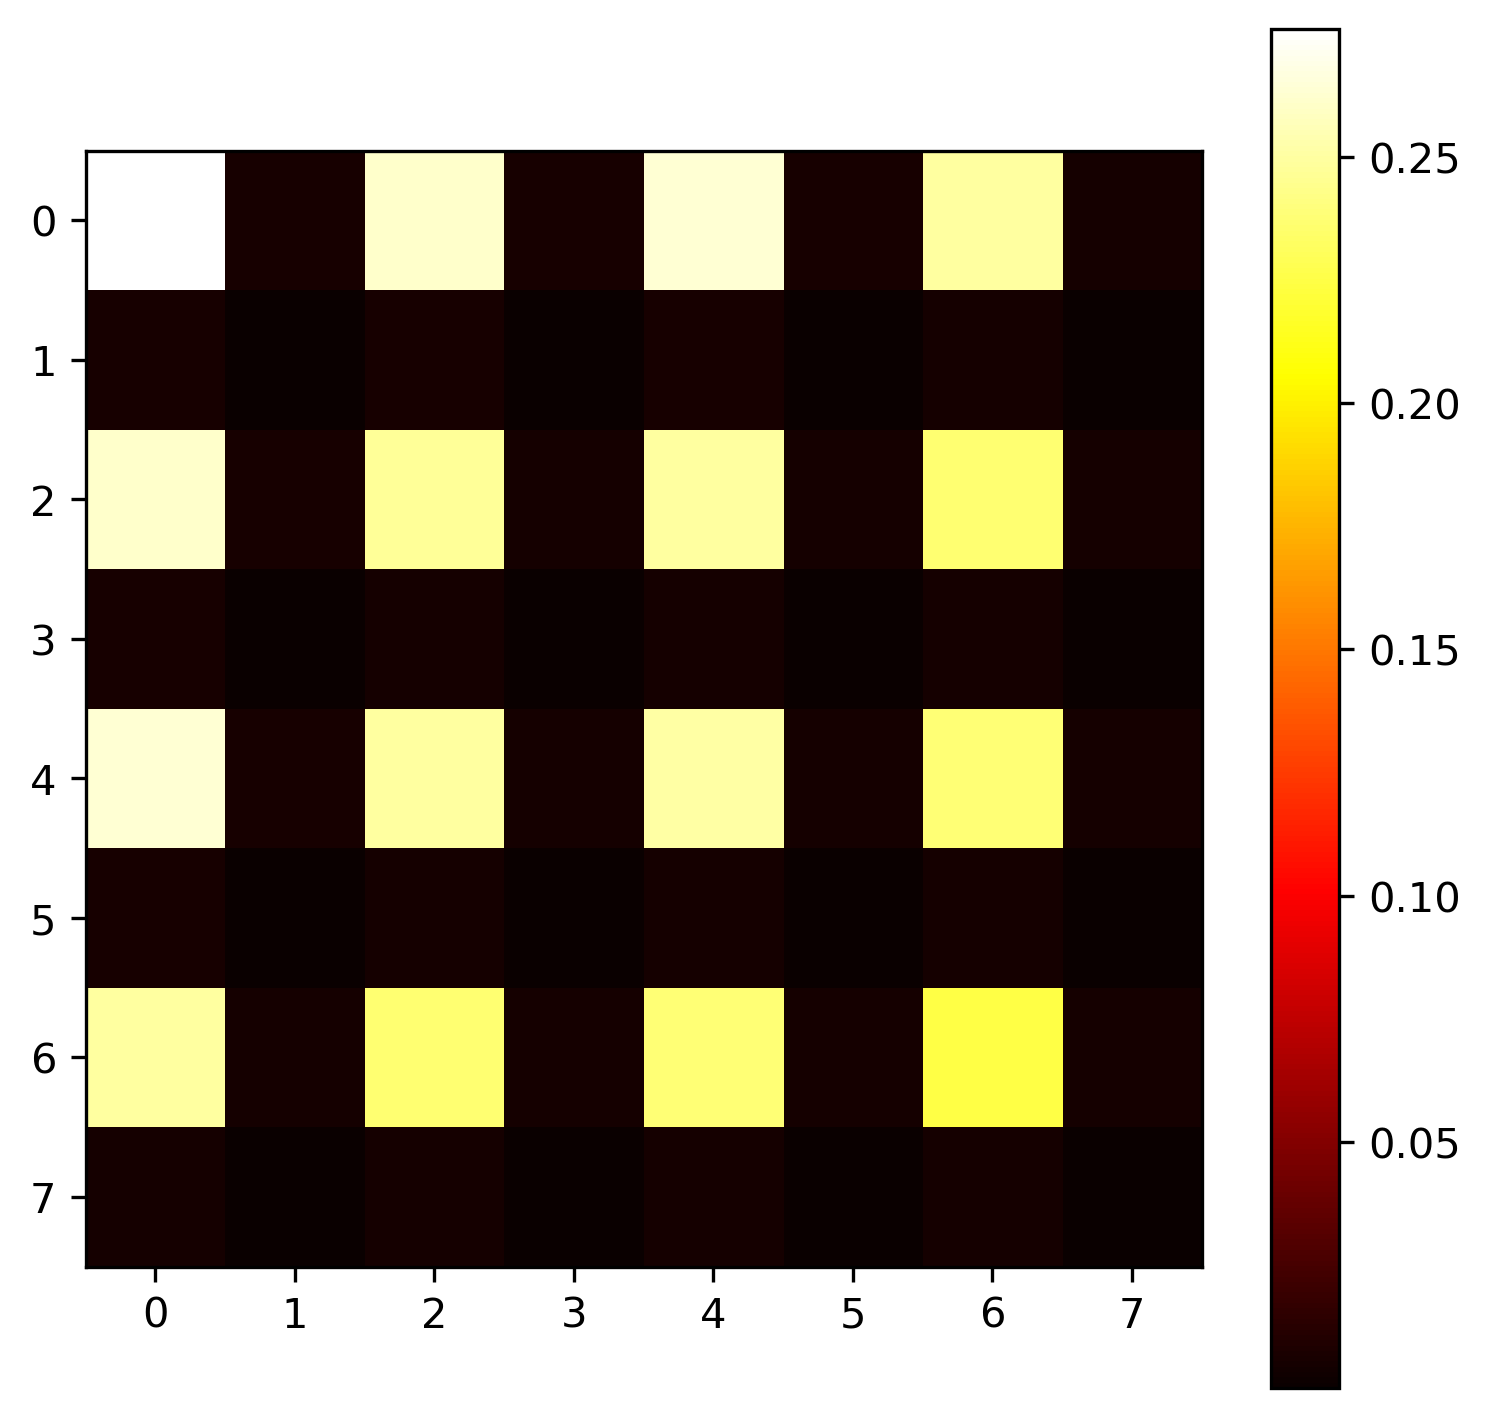

In [9]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

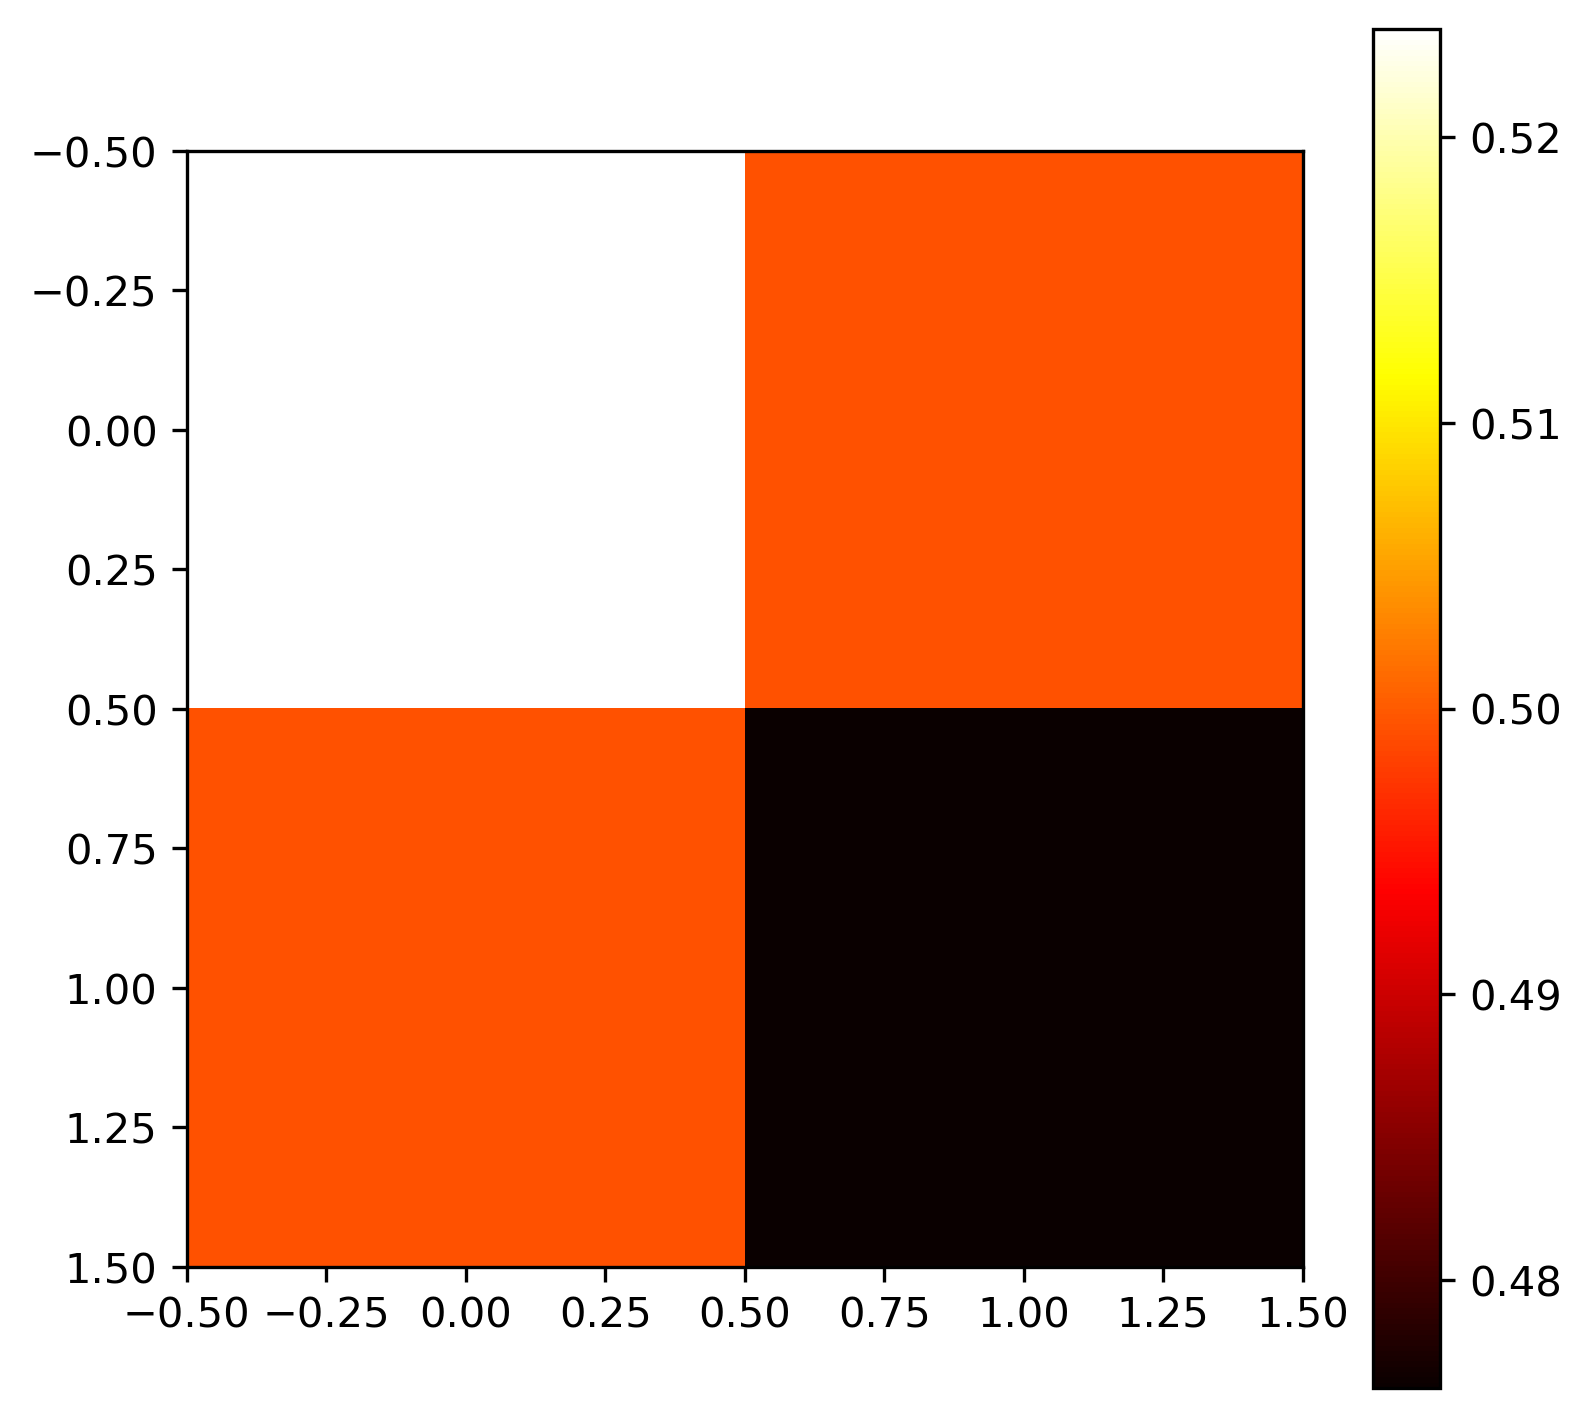

In [10]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state1), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

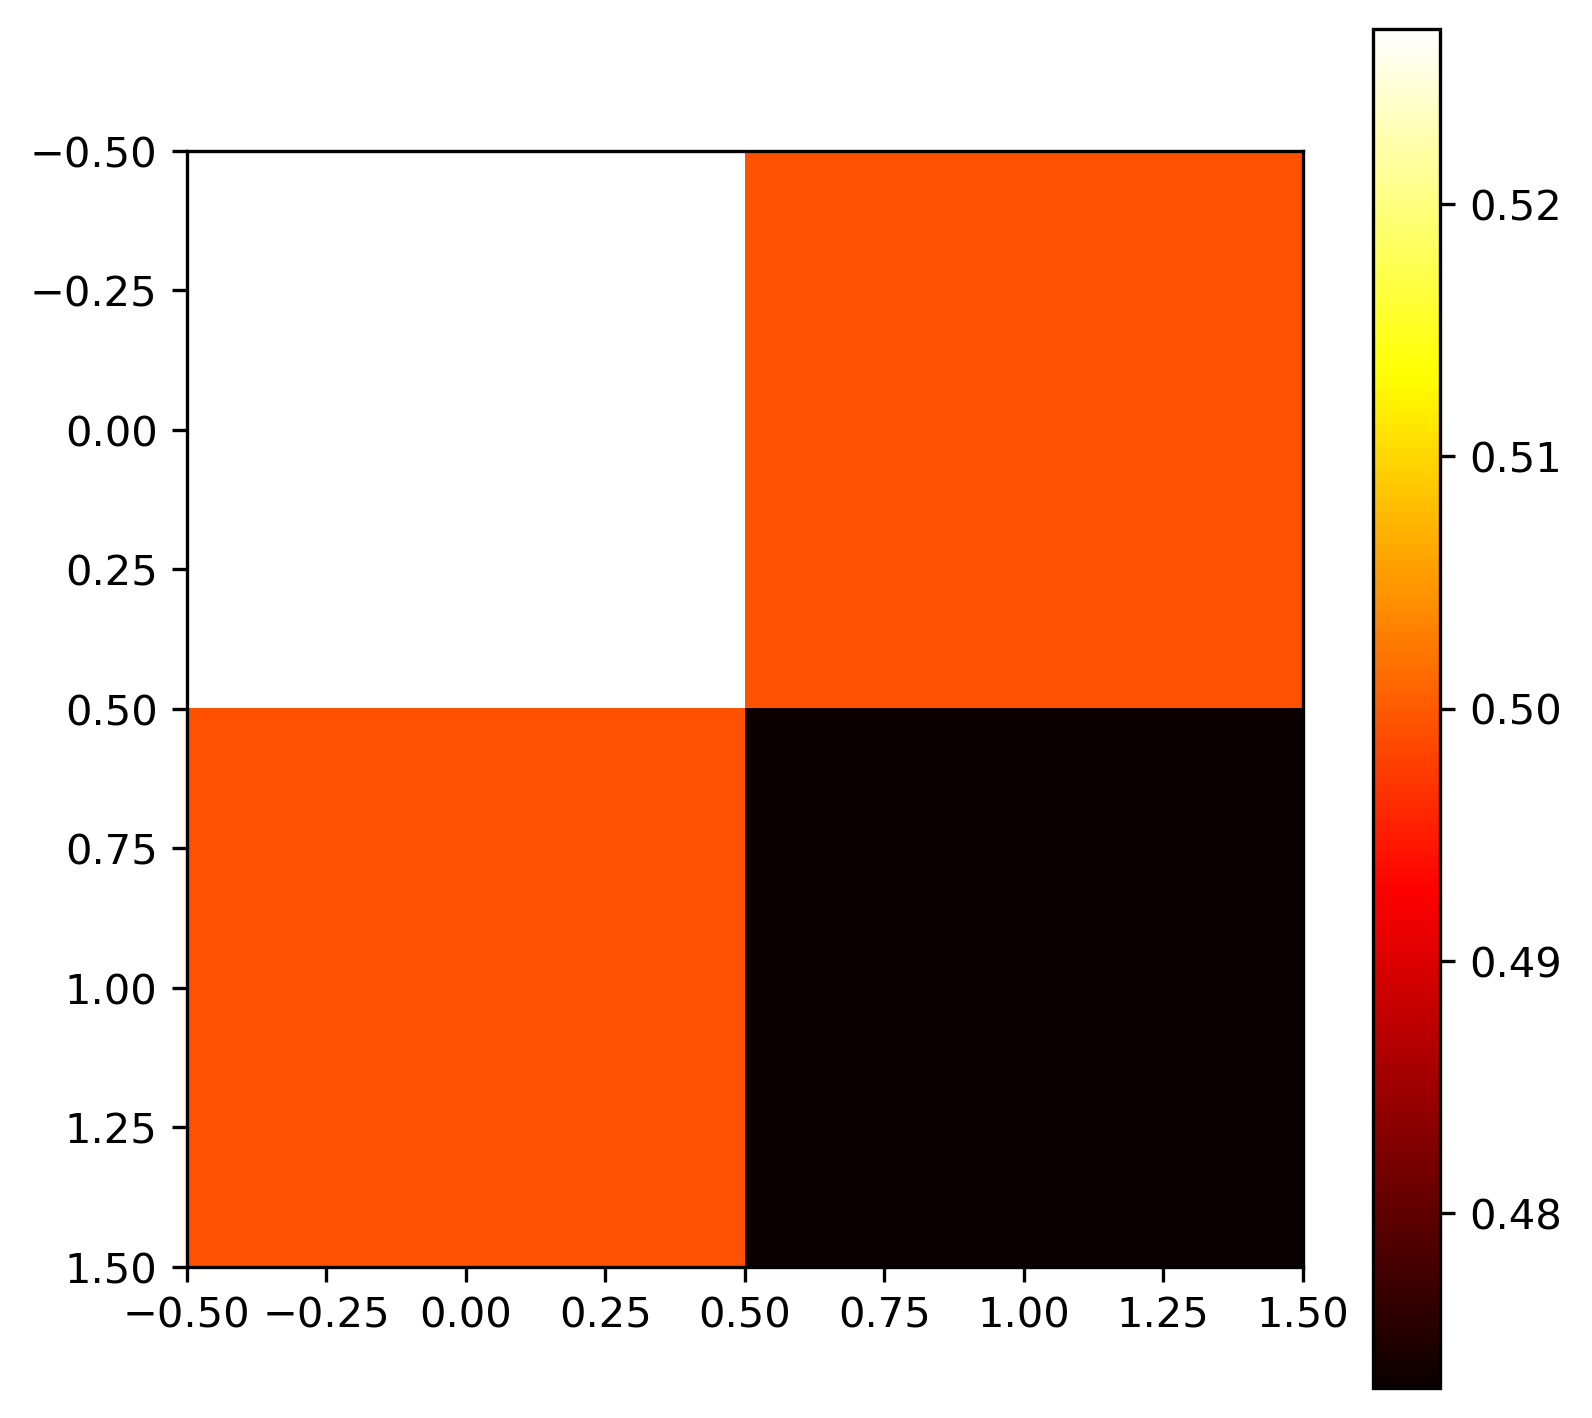

In [11]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state2), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

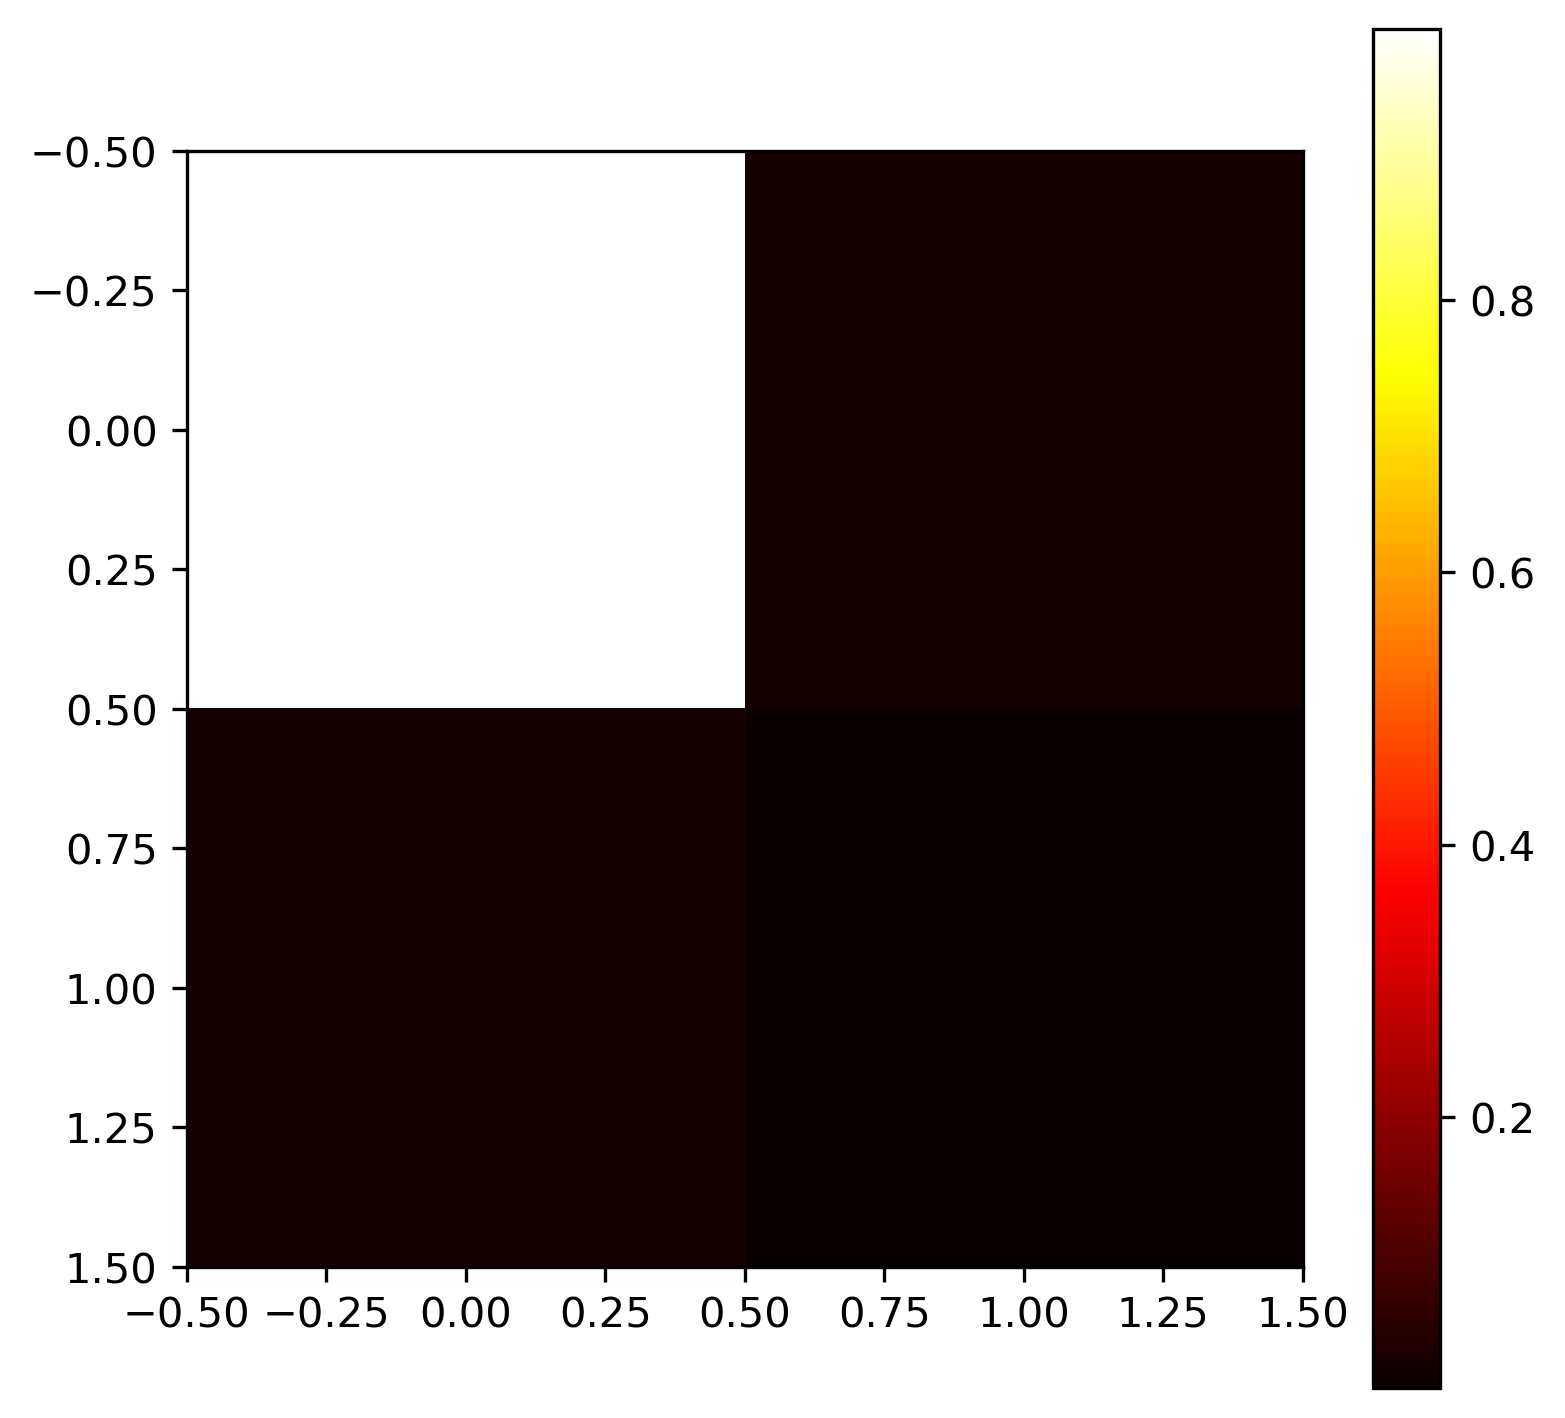

In [12]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state3), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [18]:
N = targets_map.shape[0]
d = model.channel.spam.init.shape[0]
U_prep, U_basis = inputs_map

state = tf.repeat(tf.expand_dims(model.channel.spam.init, axis=0), N, axis=0)
state = apply_unitary(state, U_prep)
state = model.channel.apply_channel(state)
output = measurement(state, U_basis, model.channel.spam.povm)

In [21]:
print(output[1], targets_map[1])

tf.Tensor(
[0.1987+8.6249e-19j 0.1471-1.7798e-18j 0.1063+1.6813e-18j
 0.0768-2.7883e-19j 0.1931+9.6475e-18j 0.1217-1.0601e-18j
 0.083 +1.9314e-18j 0.0761+1.4505e-18j], shape=(8,), dtype=complex128) tf.Tensor(
[0.215+0.j 0.145+0.j 0.107+0.j 0.078+0.j 0.166+0.j 0.129+0.j 0.07 +0.j
 0.09 +0.j], shape=(8,), dtype=complex128)
